In [ ]:
# Using google drive to access the dataset

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# All the necessary packages are imported here
!pip install nltk
# For reading the csv data into the dataframe
import pandas as pd
# For text pre-processing purposes
import nltk
from nltk import word_tokenize
import string
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
# For using the mathematical operations provided by numpy
import numpy
import numpy as np
import math

# For removing the text that belongs to the non-english languages
!pip install pycld2

import pycld2 as cld2

# For plotting the graphs
import matplotlib.pyplot as plt
# For reading and writing to the csv file
import csv

# Heap datastructure has a major in the agglomerative clustering algorithm that has been used 
import heapq

# For copying arrays and to avoid copying the addresses instead
from copy import deepcopy

# Has some functionalities that are required to calculate the kernel
import scipy.linalg

# For TF-IDF ranking to extract the tags
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

# For regular expressions
import re

# For clustering visualization
import networkx as nx

import pydot
from networkx.drawing.nx_pydot import graphviz_layout

from matplotlib import pylab

!pip install scipy==1.8.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 MB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pycld2: filename=pycld2-0.41-cp39-cp39-linux_x86_64.whl size=9915684 sha256=6b5b04a60c7d23550e457e7a21cd2fa3b017d13381f2fcd19d0444def74a7076
  Stored in directory: /root/.cache/pip/wheels/ed/98/60/230df7a9368a02bf62e0e2719a31615b2aa82238dea526b637
Successfully built pycld2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 16.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1


In [ ]:
# dataset_path variable stores the path to the dataset in the google drive

dataset_path = '/content/drive/MyDrive/dataset/'

# tweets variable contains the data of all the tweets in the form of a dataframe

tweets = pd.read_csv(dataset_path+'full-corpus.csv')

In [ ]:
# tweet2topic is a dictionary that takes the id of a tweet and gives the name of the class that tweet belongs to

tweet2topic = dict()

# id2text is a dictionary that takes the id of a tweet and gives the text of the particular tweet

id2text = dict()

In [ ]:
# Populating the dictionaries with appropriate values

for i in range(len(tweets)):
  id = tweets.iloc[i]['TweetId']
  tweet2topic[id] = tweets.iloc[i]['Topic']
  id2text[id] = tweets.iloc[i]['TweetText']

# removing http links from the text data using regular expressions

for (id, text) in id2text.items():
  id2text[id] = re.sub(r'http\S+', '', text)


In [ ]:
# bw() is a function that takes three variables a,b and c and returns whether tha value of a is in the range [b,c]

def bw(a, b, c):
  return (ord(a) >= ord(b) and ord(a) <= ord(c))

# alphanum() takes a text and removes all the non-alphanumeric characters and returns it

def alphanum(text):
  res = ""
  for x in text:
    if bw(x,'a','z') or bw(x,'A','Z') or bw(x,'0','9') or x == ' ':
      res += x
  return res

In [ ]:
# editing the values of id2text by removing the non-alphanumeric characters to make the text preprocessing easier

for (id, text) in id2text.items():
  id2text[id] = alphanum(text)

# delids is an array to store ids of all the tweets that needs to be deleted

delids = []

# detecting the language used in the text and adding the ids of non englisht texts to the delids array

for (id, text) in id2text.items():
  _,_,_, detected_language = cld2.detect(text, returnVectors = True)
  lang = detected_language[0][3]
  if lang != 'en':
    delids.append(id)

# removing the occurences of delids in id2text and tweet2topic

for x in delids:
  del id2text[x]
  del tweet2topic[x]

In [ ]:
# clean is a function that takes a text and preprocess it by removing the extra spaces

def clean(text):
  text = text.lower()
  printable = set(string.printable)
  text = list(filter(lambda x: x in printable, text)) #filter funny characters, if any.
  res = ''
  for x in text:
    res += x
  return res

# the function that extracts keywords using PageRank algorithm

def extract_keywords(Text):
  Cleaned_text = clean(Text)

  res = ''
  
  for x in Cleaned_text:
    if (ord(x) <= ord('z') and ord(x) >= ord('a')) or (ord(x) <= ord('Z') and ord(x) >= ord('A')) or x == "'":
      res += x
    elif x == '.':
      res += x
      res += ' '
    else:
      res += ' '
    
  Cleaned_text = res

  text = word_tokenize(Cleaned_text)

  # POS tagging

  POS_tag = nltk.pos_tag(text)

  # Lemmatization

  wordnet_lemmatizer = WordNetLemmatizer()
  adjective_tags = ['JJ','JJR','JJS']
  lemmatized_text = []
  for word in POS_tag:
    if word[1] in adjective_tags:
      lemmatized_text.append(str(wordnet_lemmatizer.lemmatize(word[0],pos="a")))
    else:
      lemmatized_text.append(str(wordnet_lemmatizer.lemmatize(word[0]))) #default POS = noun
  
  POS_tag = nltk.pos_tag(lemmatized_text)

  # POS based filtering

  stopwords = []

  wanted_POS = ['NN','NNS','NNP','NNPS','JJ','JJR','JJS','VBG','FW'] 

  for word in POS_tag:
    if word[1] not in wanted_POS:
      stopwords.append(word[0])
  
  punctuations = list(str(string.punctuation))

  stopwords = stopwords + punctuations

  # complete stopword generation

  stopword_file = open(dataset_path + "long_stopwords.txt","r")

  lots_of_stopwords = []

  for line in stopword_file.readlines():
    lots_of_stopwords.append(str(line.strip()))
  
  stopwords_plus = []
  stopwords_plus = stopwords + lots_of_stopwords
  stopwords_plus = set(stopwords_plus)

  # removing stopwords

  processed_text = []
  for word in lemmatized_text:
      if word not in stopwords_plus:
          processed_text.append(word)

  # vocabulary creation

  vocabulary = list(set(processed_text))

  # graph creation

  vocab_len = len(vocabulary)

  weighted_edge = np.zeros((vocab_len,vocab_len),dtype=np.float32)

  score = np.zeros((vocab_len),dtype=np.float32)
  window_size = 3
  covered_coocurrences = []

  for i in range(0,vocab_len):
      score[i]=1
      for j in range(0,vocab_len):
          if j==i:
              weighted_edge[i][j]=0
          else:
              for window_start in range(0,(len(processed_text)-window_size+1)):
                  
                  window_end = window_start+window_size
                  
                  window = processed_text[window_start:window_end]
                  
                  if (vocabulary[i] in window) and (vocabulary[j] in window):
                      
                      index_of_i = window_start + window.index(vocabulary[i])
                      index_of_j = window_start + window.index(vocabulary[j])
                      
                      # index_of_x is the absolute position of the xth term in the window 
                      # (counting from 0) 
                      # in the processed_text
                        
                      if [index_of_i,index_of_j] not in covered_coocurrences:
                          weighted_edge[i][j]+=1/math.fabs(index_of_i-index_of_j)
                          covered_coocurrences.append([index_of_i,index_of_j])

  # calculation weighted summation of connections of a vertex

  inout = np.zeros((vocab_len),dtype=np.float32)

  for i in range(0,vocab_len):
      for j in range(0,vocab_len):
          inout[i]+=weighted_edge[i][j]
  
  # scoring vertices

  MAX_ITERATIONS = 10
  d=0.85
  threshold = 0.0001 #convergence threshold

  for iter in range(0,MAX_ITERATIONS):
    prev_score = np.copy(score)
    
    for i in range(0,vocab_len):
      
      summation = 0
      for j in range(0,vocab_len):
        if weighted_edge[i][j] != 0:
          summation += (weighted_edge[i][j]/inout[j])*score[j]
              
      score[i] = (1-d) + d*(summation)
    
    if np.sum(np.fabs(prev_score-score)) <= threshold: #convergence condition
      break
        
  # phrase partitioning

  phrases = []

  phrase = " "
  for word in lemmatized_text:
    
    if word in stopwords_plus:
      if phrase!= " ":
          phrases.append(str(phrase).strip().split())
      phrase = " "
    elif word not in stopwords_plus:
      phrase+=str(word)
      phrase+=" "
    
  phrases = []

  phrase = " "
  for word in lemmatized_text:
    
    if word in stopwords_plus:
      if phrase!= " ":
        phrases.append(str(phrase).strip().split())
      phrase = " "
    elif word not in stopwords_plus:
      phrase+=str(word)
      phrase+=" "
  
  # creating a list of unique phrases

  unique_phrases = []

  for phrase in phrases:
    if phrase not in unique_phrases:
      unique_phrases.append(phrase)
  

  # thinning the list of candidate-keyphrases

  for word in vocabulary:
    #print word
    for phrase in unique_phrases:
      if (word in phrase) and ([word] in unique_phrases) and (len(phrase)>1):
        #if len(phrase)>1 then the current phrase is multi-worded.
        #if the word in vocabulary is present in unique_phrases as a single-word-phrase
        # and at the same time present as a word within a multi-worded phrase,
        # then I will remove the single-word-phrase from the list.
        unique_phrases.remove([word])
  
  # scoring keyphrases

  phrase_scores = []
  keywords = []
  for phrase in unique_phrases:
    phrase_score=0
    keyword = ''
    for word in phrase:
        keyword += str(word)
        keyword += " "
        phrase_score+=score[vocabulary.index(word)]
    phrase_scores.append(phrase_score)
    keywords.append(keyword.strip())

  i=0

  key_scores = dict()

  for keyword in keywords:
    key_scores[keyword] = phrase_scores[i]
    i+=1

  return key_scores


In [ ]:
# textrankscores is a dictionary that takes id of the text and gives the keywords along with their scores obtained from TextRank/PageRank algorithm

textrankscores = dict()

for (id, text) in id2text.items():
  textrankscores[id] = extract_keywords(text)

In [ ]:
# get_words is a function that takes text and returns the array of words present in that text

def get_words(text):
  cur = ""
  res = []
  for x in text:
    if x == ' ':
      if len(cur) > 0:
        res.append(cur)
      cur = ""
    else:
      cur += x
  if len(cur) > 0:
    res.append(cur)
  return res

# to separate the words from the keywords that contains more than one word and add the scores to those words separately

def combine(scores):
  for (id, sc) in scores.items():
    cur = dict()
    for (word, score) in sc.items():
      if count_words(word) > 1:
        for x in get_words(word):
          if x in cur.keys():
            cur[x] += score/2
          else:
            cur[x] = score
      else:
        if word in cur.keys():
          cur[word] += score
        else:
          cur[word] = score
    scores[id] = cur
  return scores

# takes text and returns number of words present in that text

def count_words(text):
  result = 0
  cur = ""
  for x in text:
    if x == ' ' and len(cur) > 0:
      result+=1
      cur = ""
      continue
    cur += x
  return result+1

# takes word to scores array and normalizes the scores from 0 to 1

def map_scale1_convert(scores):
  mx = 0
  for (word, score) in scores.items():
    mx = max(mx, score)
  for (word, score) in scores.items():
    scores[word] = score/mx
  return scores

In [ ]:
# performing the comine and normalization operations (mentioned above) on the textrankscores data

textrankscores = combine(textrankscores)

for (id, scores) in textrankscores.items():
  textrankscores[id] = map_scale1_convert(scores)

In [ ]:
# to remove unwanted characters from the text data

def pre_process(text):
  text = text.lower()
  text = re.sub("&lt;/?.*&gt;","&lt;&gt; ", text)
  text = re.sub("(\\d|\\W)+"," ",text)
  return text

# performing the necessary operations for preprocessing the documents (tweet texts) to apply the TF-IDF ranking algorithm

def process_docs(doclist):
  docs = []
  for Text in doclist:
    Cleaned_text = clean(Text)
    res = ''
    
    for x in Cleaned_text:
      if (ord(x) <= ord('z') and ord(x) >= ord('a')) or (ord(x) <= ord('Z') and ord(x) >= ord('A')) or x == "'":
        res += x
      elif x == '.':
        res += x
        res += ' '
      else:
        res += ' '
      
    Cleaned_text = res

    text = word_tokenize(Cleaned_text)

    # POS tagging

    POS_tag = nltk.pos_tag(text)

    # Lemmatization

    wordnet_lemmatizer = WordNetLemmatizer()
    adjective_tags = ['JJ','JJR','JJS']
    lemmatized_text = []
    for word in POS_tag:
      if word[1] in adjective_tags:
        lemmatized_text.append(str(wordnet_lemmatizer.lemmatize(word[0],pos="a")))
      else:
        lemmatized_text.append(str(wordnet_lemmatizer.lemmatize(word[0]))) #default POS = noun
    
    POS_tag = nltk.pos_tag(lemmatized_text)

    # POS based filtering

    stopwords = []

    wanted_POS = ['NN','NNS','NNP','NNPS','JJ','JJR','JJS','VBG','FW'] 

    for word in POS_tag:
      if word[1] not in wanted_POS:
        stopwords.append(word[0])
  
    punctuations = list(str(string.punctuation))

    stopwords = stopwords + punctuations

    # complete stopword generation

    stopword_file = open(dataset_path + "long_stopwords.txt","r")

    lots_of_stopwords = []

    for line in stopword_file.readlines():
      lots_of_stopwords.append(str(line.strip()))
    
    stopwords_plus = []
    stopwords_plus = lots_of_stopwords
    stopwords_plus = set(stopwords_plus)

    # removing stopwords

    processed_text = []
    for word in lemmatized_text:
      if word not in lots_of_stopwords:
        processed_text.append(word)

    res = ""
    for x in processed_text:
      if len(res) > 0:
        res += " "
      res += x
    docs.append(res)
  
  return docs

  

In [ ]:
# doclist stores the list of documents (tweets) that needs to be passed to be assigned TF-IDF ranking

doclist = []
for (id, text) in id2text.items():
  doclist.append(text)

docs = process_docs(doclist)

In [ ]:
# get_stop_words takes the file path where the stopwords in english language are located and returns those sopwords

def get_stop_words(stop_file_path):
  with open(stop_file_path,'r', encoding = 'utf-8') as f:
    stopwords = f.readlines()
    stop_set = set(m.strip() for m in stopwords)
    return frozenset(stop_set)

stopwords = get_stop_words(dataset_path + "stopwords.txt")

# Applying the TF-IDF ranking algorithm

cv = CountVectorizer(max_df=0.85,stop_words = list(stopwords))
word_count_vector = cv.fit_transform(docs)

tfidf_transformer = TfidfTransformer(smooth_idf = True, use_idf = True)
tfidf_transformer.fit(word_count_vector)
feature_names = cv.get_feature_names_out()

def extract(coo_matrix):
  tuples = zip(coo_matrix.col, coo_matrix.data)
  score_vals = []
  feature_vals = []

  for idx, score in sorted(tuples):
    score_vals.append(score)
    feature_vals.append(feature_names[idx])
  
  result = dict()

  for idx in range(len(feature_vals)):
    result[feature_vals[idx]] = score_vals[idx]
  
  return result

# tag_scores is a dictionary to store the (top) keywords and their corresponding scores wherease tag_scores_all stores all the keywords along with their scores
# note: tag_scores (and tag_scores_all) also has the contribution from the textrankscores (mixing of the scores from two algorithms)

tag_scores = dict()
tag_scores_all = dict()

for (id, text) in id2text.items():
  # pre processing
  text = pre_process(text)
  text = process_docs([text])
  text = text[0]
  # applying the TF-IDF
  combined_scores = extract(tfidf_transformer.transform(cv.transform([text])).tocoo())
  combined_scores = map_scale1_convert(combined_scores)

  # combined_scores is a dictionary to store keywords for each tweet along with their scores
  for (word, score) in textrankscores[id].items():
    if(count_words(word) > 1):
      continue
    if word in combined_scores.keys():
      combined_scores[word] += score
    else:
      combined_scores[word] = score
  
  tag_scores_all[id] = combined_scores

  # filtering out only the top keywords for each tweet

  combined_scores = dict(sorted(combined_scores.items(), key=lambda item: item[1], reverse = True))

  num_keywords = max(5, math.floor(count_words(text)/4))
  num_keywords = min(15, num_keywords)
  
  cur = 0

  # num_keywords stores the number of keywords to be filtered out for each tweet (base on the size of tweet)

  tag_scores[id] = dict()
  for (word, score) in combined_scores.items():
    if cur >= num_keywords:
      break
    tag_scores[id][word] = score
    cur += 1


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['come', 'vis', 'viser', 'visest'] not in stop_words.
  warnings.warn(


In [ ]:
# this class is to find the exponential of the given matrix (also known as kernel exponentiation)
# note: only works for symmetric matrices

class kernelexponentiation:
  def __init__(self, mat):

    self.n = len(mat)

    # column sum is an array storing the sum of elements in each column

    column_sum = numpy.zeros(self.n)
    for i in range(self.n):
      for j in range(self.n):
        column_sum[j] += mat[i][j]

    D = numpy.diag(column_sum)

    # finding the negated leplacian matrix which helps in calculatint the exponential of a matrix

    self.mat = numpy.subtract(mat, D)

    # self.EV contains the eigen values of calculated negated leplacians matrix
    # similarly self.V contains the eigen vectors and self.VT is the transpose of eigen vectors 
    curres = numpy.linalg.eig(self.mat)
    self.EV = curres[0]
    self.V = curres[1]
    self.VT = numpy.transpose(self.V)

  # computing the exponential using the formuala
  def get_kernel(self,beta):
    res = numpy.matmul(self.V, scipy.linalg.expm(numpy.diag(beta*self.EV)))
    res = numpy.matmul(res, self.VT)
    for i in range(num_tags):
      for j in range(num_tags):
        # removing the complex values
        res[i][j] = res[i][j].real
    return res

# takes range [l,r] and returns n unique numbers from the range randomly

def get_rand(n, l, r):
  res = []
  while len(res) < n:
    cur = numpy.random.randint(l,r)
    if cur in res:
      continue
    res.append(cur)
  return res

In [ ]:
# id2tags is a dictionary that takes the id of the tweet and returns the corresponding keywords/tags (without the scores)

id2tags = dict()

# populating id2tags

for (id, scores) in tag_scores.items():
  id2tags[id] = []
  for (word, score) in scores.items():
    id2tags[id].append(word)

# taghash is a dictionary that hashes the tags to a unique number for better usage in the future

taghash = dict()
cur = 0

# populating tag2hash

for (id, taglist) in id2tags.items():
  for tag in taglist:
    if tag in taghash.keys():
      continue
    taghash[tag] = cur
    cur += 1

# tags is a list of strings storing all the unique tags

tags = []

for tag in taghash.keys():
  tags.append(tag)

# num_tags variable denotes the total number of tags present

num_tags = len(taghash)

# tag_network is 2d array that stores the desired tag network in adjacency matrix form

tag_network = numpy.zeros([num_tags, num_tags])

for (id, taglist) in id2tags.items():
  n = len(taglist)
  for i in range(n):
    for j in range(n):
      tag_network[taghash[taglist[i]]][taghash[taglist[j]]] += 1

In [ ]:
# the class mentioned above is loaded into the variable kexp with the matrix being tag_network

kexp = kernelexponentiation(tag_network)

In [ ]:
# ids is a list of all the unique ids of the tweets present in the dataset

ids = []

# populating the list ids

for id in id2text.keys():
  ids.append(id)

# num_posts is a variable storing the total number of posts 

num_posts = len(ids)

# idhash is a dictionary that maps each id to a unique number for simplified usage of ids in the future

idhash = dict()

for i in range(num_posts):
  idhash[ids[i]] = i

# from this point id2tags maps ids to the hash value of tags mentioned in the taghash dictionary

for (id, taglist) in id2tags.items():
  curres = []
  for x in taglist:
    curres.append(taghash[x])
  id2tags[id] = curres

In [ ]:
print(len(ids))

3215


In [ ]:
# get_cosine_sim is a function that takes two arrays of keywords along with their scores and returns their distances in terms of cosine similarity

def get_cosine_sim(scores1, scores2):
  num = 0
  denom1 = 0
  denom2 = 0
  for (word, score) in scores1.items():
    if word in scores2.keys():
      num += score*scores2[word]
    denom1 += score*score
  
  for (word, score) in scores2.items():
    denom2 += score*score
  
  denom1 **= 0.5
  denom2 **= 0.5
  return num/denom1*denom2

# the purpose of this class is to try out the kernel exponentiation with different values of beta (diffusion constant)

class beta_computation:
  def __init__(self,beta = -1):
    self.beta = beta
    self.sim = -1
    self.K = -1
  # don't call this from outside (automatically called from inside)
  def calc_similarity_matrix(self):

    # self.sim is a 2d array for storing the similarity distances calculated from the kernel 

    self.sim = numpy.zeros([num_posts, num_posts])

    # denom is a list that stores all the denominators for each post/tweet/id

    denom = []

    for i in range(num_posts):
      denom.append(len(id2tags[ids[i]])**0.5)

    for i in range(num_posts):
      for j in range(num_posts):
        cur = 0
        for x in id2tags[ids[i]]:
          for y in id2tags[ids[j]]:
            cur += self.K[x][y]
        self.sim[i][j] = cur
    

  # takes value k, postid and returns top k tweets/posts that are similar to the given tweet which helps in calculating the value of MSI

  def get_similar_posts(self,postid, k):
    res = []
    temp = []
    curind = idhash[postid]
    for i in range(num_posts):
      if curind != i:
        temp.append((self.sim[curind][i],ids[i]))
    temp.sort(reverse=True)
    for i in range(k):
      res.append(temp[i][1])
    return res

  # only call this to set all the parameters

  # for setting the value of beta and perform the required computations for calculating the values
  # of K and calculating the distance_matrix/similarity_matrix each time
  def set_beta(self,beta):
    self.beta = beta
    self.K = kexp.get_kernel(self.beta)
    self.calc_similarity_matrix()

  # for calculating the Mean similarity index by using cosine_similarity for the top k similar
  # posts that are found according the the similarity matrix that is calculated for each value of beta
  def get_MSI_vals(self, k_similar = 200):
    num_sel = num_posts
    sel_ids = [x for x in range(0,num_posts)]
    
    for i in range(num_sel):
      sel_ids[i] = ids[sel_ids[i]]

    res = []
    for postid in sel_ids:
      res.append(self.get_similar_posts(postid, k_similar))
    
    MSI = np.zeros(k_similar)

    for j in range(k_similar):
      for i in range(num_sel):
        MSI[j] += get_cosine_sim(tag_scores_all[sel_ids[i]],tag_scores_all[res[i][j]])
  
    for i in range(k_similar): 
      MSI[i] /= num_sel
    return MSI


In [ ]:
# using the class declared above

for_computations = beta_computation()

# the values of beta that we are trying out

betas = [0.1, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001]

MSIs = []

for beta in betas:
  for_computations.set_beta(beta)
  MSIs.append(for_computations.get_MSI_vals())

<ipython-input-20-26a4a1d4281e>:46: ComplexWarning: Casting complex values to real discards the imaginary part
  self.sim[i][j] = cur


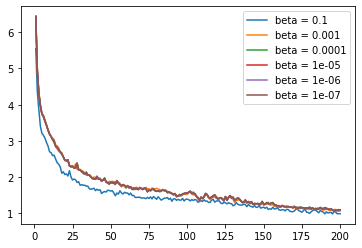

In [ ]:
# for plotting and comparing the MSI values for different values of beta

x = [x for x in range(1,201)]

for i in range(len(betas)):
  plt.plot(x, MSIs[i], label = "beta = "+str(betas[i]))

plt.legend()
plt.show()

<ipython-input-20-26a4a1d4281e>:46: ComplexWarning: Casting complex values to real discards the imaginary part
  self.sim[i][j] = cur


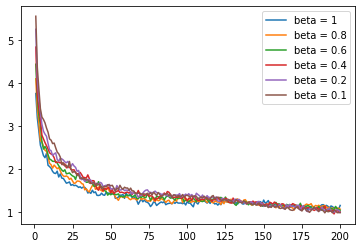

In [ ]:

# more beta values to compare

for_computations = beta_computation()

betas = [1, 0.8, 0.6, 0.4, 0.2, 0.1]

MSIs = []

for beta in betas:
  for_computations.set_beta(beta)
  MSIs.append(for_computations.get_MSI_vals())

x = [x for x in range(1,201)]

import matplotlib.pyplot as plt

for i in range(len(betas)):
  plt.plot(x, MSIs[i], label = "beta = "+str(betas[i]))

plt.legend()
plt.show()

In [ ]:
# setting the values of beta as 0.00001 from the previous results

for_computations.set_beta(0.00001)

<ipython-input-20-26a4a1d4281e>:46: ComplexWarning: Casting complex values to real discards the imaginary part
  self.sim[i][j] = cur


In [ ]:
# saving the value of beta calculated to this point into a csv file
# the computational cost of calculating the kernel (K) is expensive and we cannot afford to compute the value of kernel everytime we run the notebook

with open('drive/MyDrive/distances.csv', 'w', encoding='UTF8', newline='') as f:
  f.truncate()
  writer = csv.writer(f)
  dummy = [x for x in range(num_posts)]
  writer.writerow(dummy)
  writer.writerows(for_computations.sim)


# Kernel for beta value 0.00001 saved, can run from here ignoring the rest



In [ ]:
# For loading the similarity matrix from the drive

data = pd.read_csv("drive/MyDrive/distances.csv")
distances_matrix = data.to_numpy()

In [ ]:
# squaring the distance matrices

for i in range(num_posts):
  for j in range(num_posts):
    distances_matrix[i][j] *= distances_matrix[i][j]

In [ ]:
# normalizes a 2d matrix from 0 to 1

def normalize(mat):
  mx = mat[0][0]
  mn = mat[0][0]

  for i in range(len(mat)):
    for j in range(len(mat[i])):
      mx = max(mat[i][j], mx)
      mn = min(mat[i][j], mn)
  
  for i in range(len(mat)):
    for j in range(len(mat[i])):
      mat[i][j] = (mat[i][j]-mn)/(mx-mn)
  
  return mat

In [ ]:
# performing the normalization

distances_matrix = normalize(distances_matrix)

In [ ]:
# takes the graph and saves the visualization into google drive

def save_graph(graph,file_name, colors, main_nodes = [], sizes = None):

  # sizes of all the nodes is 200 if not specified
  if sizes == None:
    sizes = []
    for x in colors:
      sizes.append(200)
  plt.figure(num=None, figsize=(60, 60), dpi=40)
  plt.axis('off')
  fig = plt.figure(1)

  # this layout avoids overlapping of clusters
  pos = graphviz_layout(graph, prog = 'neato')
  nx.draw_networkx_nodes(graph,pos, node_color = colors, node_size = sizes,cmap='Set2')
  nx.draw_networkx_edges(graph,pos, width = 1)
  nx.draw_networkx_labels(graph,pos)

  cut = 1.00
  xmax = cut * max(xx for xx, yy in pos.values())
  ymax = cut * max(yy for xx, yy in pos.values())
  plt.xlim(0, xmax + 20)
  plt.ylim(0, ymax + 20)

  plt.savefig(file_name,bbox_inches="tight")
  pylab.close()
  del fig

In [ ]:
# this class peforms the agglomerative clustering algorithm

class agglomerative_clustering:

  # setting all the appropriate values

  def __init__(self, distance_matrix):
    # self.dist stores the distance_matrices    
    self.dist = distance_matrix
    self.num_nodes = len(self.dist)
    # performing normalization
    self.dist = normalize(self.dist)
    # self.num_clusters indicates the current number of clusters
    self.num_clusters = self.num_nodes
    # self.inter_cluster_distances is a 2d matrix that stores the summation of the distances among the nodes in the two clusters
    self.inter_cluster_distances = deepcopy(self.dist)
    # self.is_cluster_head indicates whether a node is head of its cluster
    self.is_cluster_head = [True for x in range(self.num_nodes)]
    # self.belongs_to stores the head node of the cluster which the current node belongs to
    self.belongs_to = [x for x in range(self.num_nodes)]
    # self.cluster[head_node] stores the nodes in the clusters whose head node is head_node 
    self.cluster = [[x] for x in range(self.num_nodes)]
    # self.merges records all the merges that are done
    self.merges = []
    # self.heap stores the inter_cluster_distances and dynamically returns the closest clusters each time
    # each element of the heap is in format [distances, head node of cluster 1, head node of cluster 2, iteration when pushed]
    # note: the iteration of pushing is noted to identify whether to identify the distances after the push has happened
    self.heap = []
    # self.real stores the real class of the nodes
    self.real = []
    # self.last_updated stores the last iteration in which the inter_cluster_distances between the two clusters was updated
    self.last_updated = np.zeros([self.num_nodes, self.num_nodes])
    # self.iter stores the current number of iterations performed
    self.iter = 0
    
  def visualize(self):
    # color values on the scale from 0 to 1 on 'Set2' color map
    color_list = [0.2, 0.4, 0.6, 0.8]
    cols = []
    cur = 0
    # for mapping clustering name to number 
    realdict = dict()
    for topic in self.real:
      if topic in realdict.keys():
        continue
      realdict[topic] = cur
      cur += 1

    sizes = []
    G=nx.Graph()
    for i in range(self.num_nodes):
      G.add_node(i)
      cols.append(realdict[self.real[i]])

      # head nodes to be bigger in sizes to be identifiable
      if self.is_cluster_head[i] and len(self.cluster[i]) > 4:
        sizes.append(1000)
      else:
        sizes.append(300)

    # adding edges to the graph
    for edge in self.merges:
      G.add_edge(edge[0],edge[1])

    # specifying path for graph that needs to be saved"
    path = "drive/MyDrive/VisualizationGraph-" + str(self.num_clusters) + ".pdf"

    save_graph(G,path, cols, sizes = sizes)

  # for calculating f1-score, precision and recall at the point where the function is called
  def calc_scores(self):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i in range(num_posts):
      for j in range(i+1,num_posts):
        if self.real[i] == self.real[j]:
          if self.belongs_to[i] == self.belongs_to[j]:
            tp+=1
          else:
            fp+=1
        else:
          if self.belongs_to[i] == self.belongs_to[j]:
            fn+=1
          else:
            tn+=1
    precision = tp/(tp + fp)
    recall = tp/(tp + fn)
    f1 = 2*precision*recall/(precision+recall)
    print("f1-score = ",f1,"recall = ",recall, "precision = ", precision)
  
  # to get the distribution of the real classes of nodes in each cluster
  def get_distribution(self):
    for i in range(self.num_nodes):
      if self.is_cluster_head[i]:
        # considering only clusters with size >= 50 for the output 
        if len(self.cluster[i]) < 50:
          continue
        distribution = dict()
        for x in self.cluster[i]:
          if self.real[x] not in distribution.keys():
            distribution[self.real[x]] = 1
          else:
            distribution[self.real[x]] += 1
        print("cluster-id:",i,distribution)

  # for setting the values of real classes of nodes
  def set_real_clusters(self, real):
    self.real = real

  # for getting the average distance between nodes in two clusters from inter_cluster_distances by dividing with appropriate value
  def get_inter_cluster_distance(self, u, v):
    return self.inter_cluster_distances[u][v]/(len(self.cluster[u])*len(self.cluster[v]))

  # this is the point where clustering starts
  def go(self, visualization = False):
    
    # initially populating the heap

    for i in range(self.num_nodes):
      for j in range(self.num_nodes):
        if i >= j:
          continue
        self.heap.append([-self.dist[i][j], i, j, self.iter])
    # getting the top element heap (and finding the most similar clusters)
    heapq.heapify(self.heap)
    # performing the clustering untill all the nodes are merged
    while len(self.heap) != 0:
      # u represents to top element in the heap
      u = heapq.heappop(self.heap)
      if self.is_cluster_head[u[1]] and self.is_cluster_head[u[2]] and self.last_updated[u[1]][u[2]] == u[3] and (len(self.cluster[u[1]]) + len(self.cluster[u[2]]) <= 1000 or self.num_clusters <= 4):
        # incrementing the number of iterations
        self.iter += 1
        # combining the two clusters using the funtion that is defined below
        self.combine(u[1],u[2])
        self.num_clusters-=1
        # printing the scores
        if self.num_clusters%500 == 0 or (self.num_clusters <= 500 and self.num_clusters%100 == 0) or (self.num_clusters <= 100 and self.num_clusters%10 == 0) or (self.num_clusters <= 10):
          print("No. of clusters = ", self.num_clusters)
          self.calc_scores()
          if(visualization):
            self.visualize()
          if self.num_clusters <= 1000:
            print("clusters: ")
            self.get_distribution()

  # this function takes head nodes and combines the clusters corresponding to the head nodes
  def combine(self, x, y):
    # recording the merge
    self.merges.append([x,y])
    # new head of the cluster
    # note: new head is always the head node of the largest cluster as the cluster with smaller size is merged into the cluster with larger size
    new_head = x
    # pilla_cluster_head represents the head of the smaller cluster
    pilla_cluster_head = y
    if len(self.cluster[x]) < len(self.cluster[y]):
      new_head = y
      pilla_cluster_head = x
    
    # changing the status of is_cluster_head for the head of smaller cluster as it is no longer head of the cluster
    self.is_cluster_head[pilla_cluster_head] = False

    # recalculatint the inter_cluster_distances for all clusters to the current cluster as new nodes are added into the cluster
    for i in range(self.num_nodes):
      if self.is_cluster_head[i] == False or (i == new_head):
        continue
      
      self.inter_cluster_distances[i][new_head] += self.inter_cluster_distances[i][pilla_cluster_head]
      self.inter_cluster_distances[new_head][i] = self.inter_cluster_distances[i][new_head]
      # recording the latest updation
      self.last_updated[i][new_head] = self.iter
      self.last_updated[new_head][i] = self.iter
      denom = (len(self.cluster[i])*(len(self.cluster[new_head]) + len(self.cluster[pilla_cluster_head])))
      # pushing the updated value
      heapq.heappush(self.heap, [-self.inter_cluster_distances[i][new_head]/denom, i, new_head, self.iter])

    # merging the nodes into the new cluster
    for node in self.cluster[pilla_cluster_head]:
      self.belongs_to[node] = new_head
      self.cluster[new_head].append(node)


In [ ]:
# calculating the values of real classes of all the nodes from the id2topic dictionary mentioned above

realclusters = [' ' for x in range(num_posts)]

for (id, topic) in tweet2topic.items():
  realclusters[idhash[id]] = topic

# performing clustering using the class declared above
clustering_object = agglomerative_clustering(distances_matrix)
# assigning the real class values of the nodes
clustering_object.set_real_clusters(realclusters)
# note: clusters are visualized if only specified
clustering_object.go()

No. of clusters =  3000
f1-score =  0.0008865123165071712 recall =  0.996661101836394 precision =  0.0004434533801992495
No. of clusters =  2500
f1-score =  0.004934660208633877 recall =  0.983751846381093 precision =  0.0024735339297546075
No. of clusters =  2000
f1-score =  0.01734941461920803 recall =  0.967487684729064 precision =  0.008753190338807296
No. of clusters =  1500
f1-score =  0.02636604926106931 recall =  0.9591706199029902 precision =  0.01336673965943969
No. of clusters =  1000
f1-score =  0.06696177673155222 recall =  0.9257646243689993 precision =  0.03473718144894121
clusters: 
cluster-id: 58 {'apple': 53, 'microsoft': 1}
cluster-id: 743 {'apple': 49, 'google': 1, 'microsoft': 4}
cluster-id: 750 {'apple': 117, 'google': 1}
cluster-id: 1137 {'google': 82, 'apple': 1, 'microsoft': 1}
cluster-id: 1265 {'google': 147, 'microsoft': 2}
cluster-id: 1446 {'google': 85}
cluster-id: 1866 {'microsoft': 63, 'apple': 3}
cluster-id: 2792 {'twitter': 141, 'apple': 2, 'google': 6}

In [ ]:
# the same algorithm but now distances are measured using the cosine similarity of the scores instead

cosine_distances = np.zeros([num_posts, num_posts])

for i in range(num_posts):
  for j in range(num_posts):
    if i != j:
      cosine_distances[i][j] = get_cosine_sim(tag_scores_all[ids[i]], tag_scores_all[ids[j]])

In [ ]:
cosine_distances = normalize(cosine_distances)

In [ ]:
clustering_object = agglomerative_clustering(cosine_distances)

clustering_object.set_real_clusters(realclusters)

clustering_object.go()

No. of clusters =  3000
f1-score =  0.0009251030346497861 recall =  0.9968 precision =  0.00046276625772886503
No. of clusters =  2500
f1-score =  0.009502371157265203 recall =  0.9944298313476714 precision =  0.004773994764724583
No. of clusters =  2000
f1-score =  0.01790763153285617 recall =  0.9648691514670896 precision =  0.009037683880878172
No. of clusters =  1500
f1-score =  0.026299304785761334 recall =  0.9623076510642861 precision =  0.01333182791929
No. of clusters =  1000
f1-score =  0.039479836501760124 recall =  0.9383014759254779 precision =  0.020164129746882455
clusters: 
cluster-id: 162 {'apple': 62, 'google': 3}
cluster-id: 1288 {'google': 142, 'microsoft': 2}
cluster-id: 1553 {'google': 116}
cluster-id: 1869 {'microsoft': 59}
No. of clusters =  500
f1-score =  0.10280772105825724 recall =  0.8640409591582705 precision =  0.05465544340881202
clusters: 
cluster-id: 162 {'apple': 106, 'google': 6}
cluster-id: 755 {'apple': 50, 'microsoft': 7}
cluster-id: 1237 {'google

In [ ]:
# combining both the distances (from kernel exponentiation and cosine distances)

combined_distances = np.zeros([num_posts, num_posts])

In [ ]:
for i in range(num_posts):
  for j in range(num_posts):
    combined_distances[i][j] = distances_matrix[i][j] + cosine_distances[i][j]

In [ ]:
clustering_object = agglomerative_clustering(combined_distances)

clustering_object.set_real_clusters(realclusters)

clustering_object.go()

No. of clusters =  3000
f1-score =  0.0008182339956177704 recall =  1.0 precision =  0.0004092844430314681
No. of clusters =  2500
f1-score =  0.008964584567220706 recall =  0.9807474518686297 precision =  0.004502871676328057
No. of clusters =  2000
f1-score =  0.019019024909053196 recall =  0.9696265186740664 precision =  0.009603699753092288
No. of clusters =  1500
f1-score =  0.028399688806626102 recall =  0.965225610666136 precision =  0.014411863454984653
No. of clusters =  1000
f1-score =  0.039371630579520325 recall =  0.9399284697385326 precision =  0.020106933917275516
clusters: 
cluster-id: 572 {'apple': 54, 'google': 2}
cluster-id: 1287 {'google': 149, 'microsoft': 2}
cluster-id: 1553 {'google': 101}
cluster-id: 1869 {'microsoft': 52, 'google': 1}
No. of clusters =  500
f1-score =  0.12189015597466321 recall =  0.9079562699371303 precision =  0.06533026506181606
clusters: 
cluster-id: 502 {'apple': 54, 'google': 2, 'microsoft': 5}
cluster-id: 572 {'apple': 96, 'google': 3, 